# Import Libraries

Nama: Irsyad Fadhil Makarim
Kode Peserta: GEA01I008

Tugas: Assignment 3

In [10]:
pip install phik

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 9.5 MB/s eta 0:00:00


In [11]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
import phik

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, precision_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split


# Load Dataset

In [12]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


# Exploratory Data Analysis

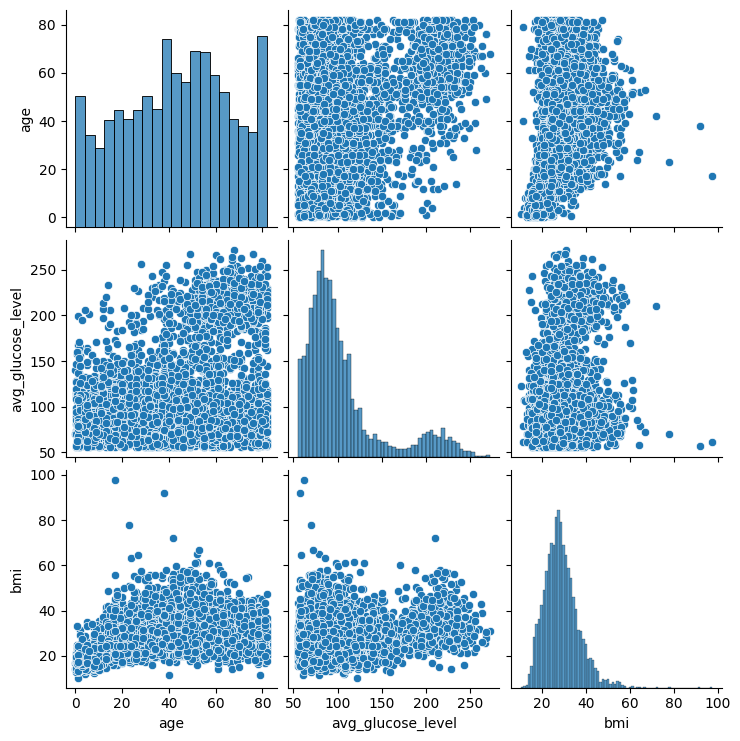

In [13]:
sns.pairplot(df[['age', 'avg_glucose_level', 'bmi']])

Pair plot tersebut untuk menunjukkan hubungan kolom yang memiliki nilai kontinu, dalam pair plot tersebut terdapat beberapa plot yang berpotensi memiliki nilai outlier pada kolom age vs bmi dan avg_glucose_level vs bmi.

<Axes: xlabel='age', ylabel='Count'>

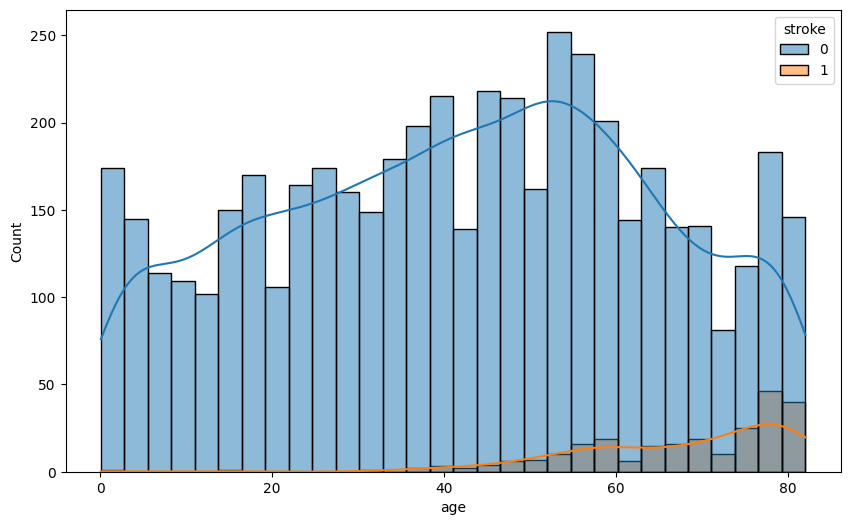

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='stroke', bins=30, kde=True)

Walaupun terdapat ketimpangan perbandingan data yang besar, dapat disimpulkan semakin tinggi umur maka semakin tinggi resiko terkena stroke

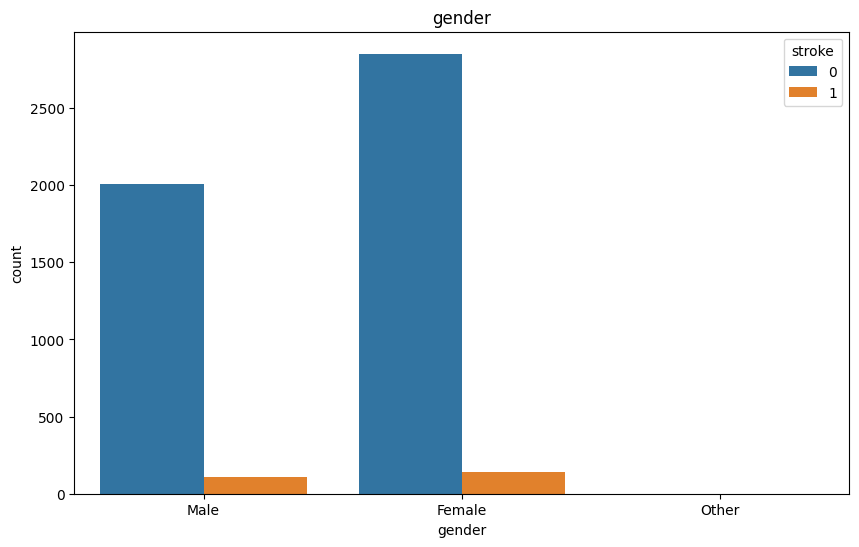

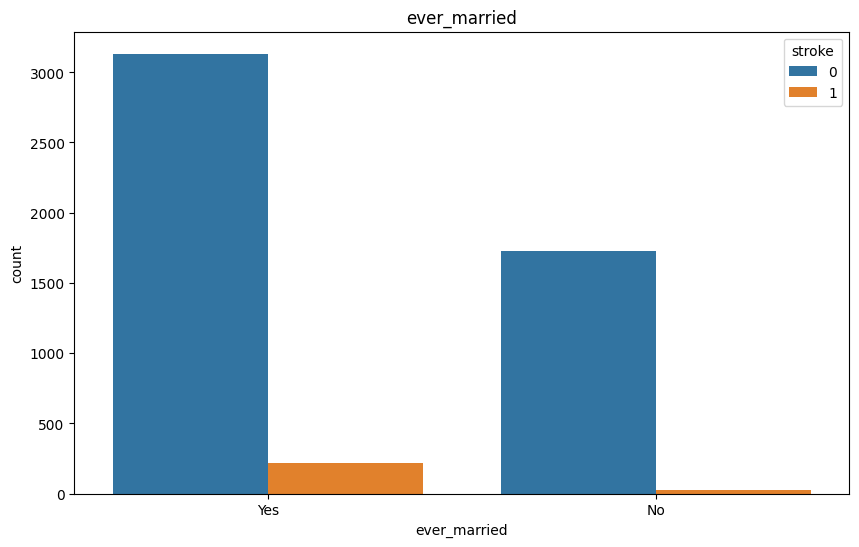

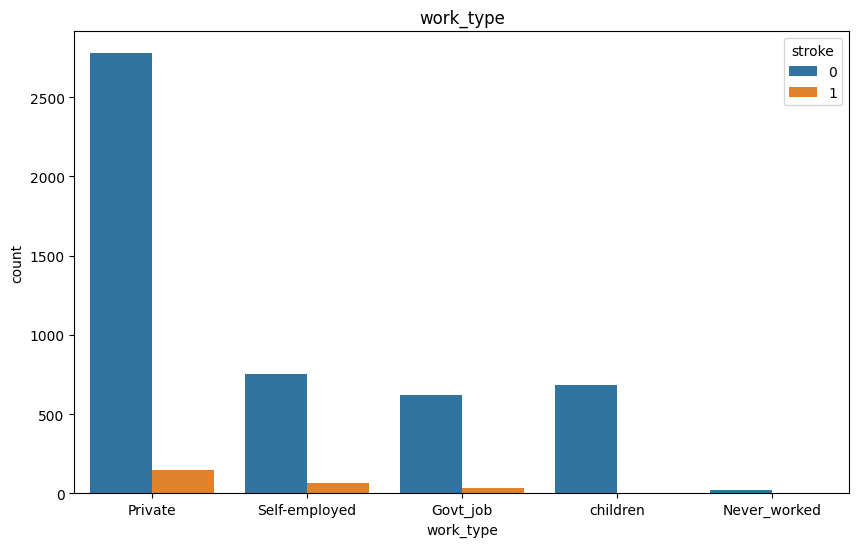

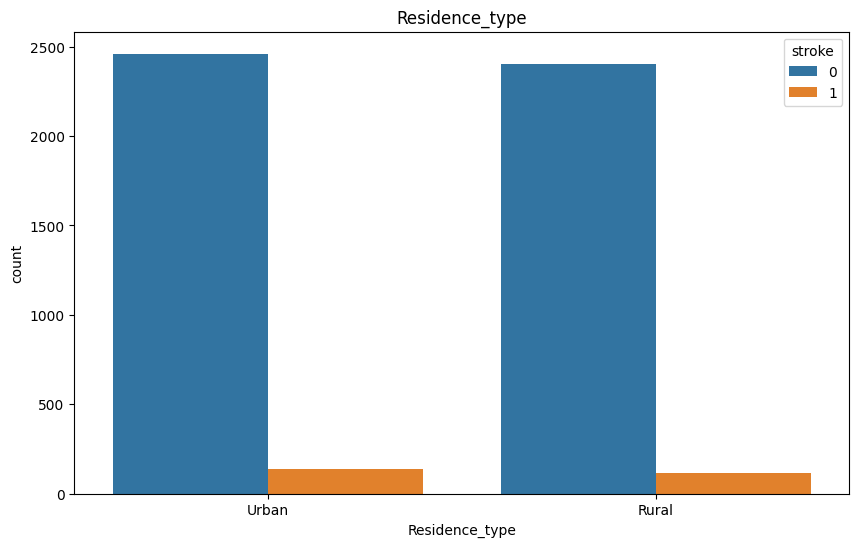

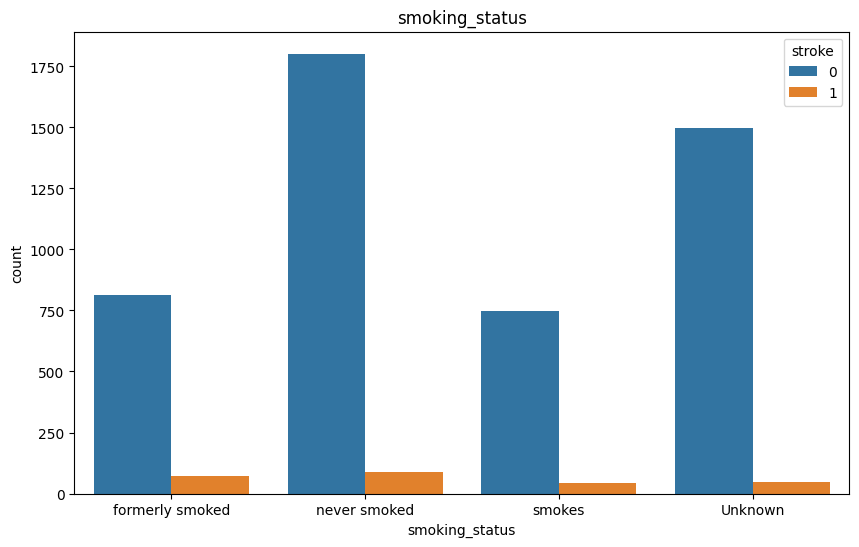

In [15]:
for i in df.select_dtypes('object').columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=i, hue='stroke')
    plt.title(i)
    plt.show()

Dari beberapa plot diatas dapat disimpulkan beberapa hal:
- Gender 'Female' sedikit menunjukkan resiko terkena stroke sedikit lebih tinggi dibandingkan 'Male', akan tetapi tidak menunjukkan perbedaan yang signifikan, oleh karena itu tidak bisa dijadikan hubungan yang kuat
- 'ever_married' menunjukkan resiko terkena stroke lebih tinggi jika orang tersebut dalam status menikah.
- Pada kolom 'work_type' dengan nilai 'private' menunjukkan resiko stroke lebih tinggi dibandingkan jenis pekerjaan yang lain.
- 'Residence_type' menunjukkan perbandingan yang mirip yang kemungkinan besar tidak berpengaruh pada resiko stroke.
- Kolom 'smoking_status' menunjukkan bahwa nilai 'never_smoked' berkemungkinan paling tinggi terkena stroke.

In [16]:
df_corr = df.drop(['id', 'avg_glucose_level'], axis=1).phik_matrix(interval_cols=['age'])
df_corr

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,bmi,smoking_status,stroke
gender,1.000000,0.131822,0.005391,0.050287,0.017990,0.078392,0.000000,0.000000,0.075278,0.000000
age,0.131822,1.000000,0.368769,0.388504,0.927262,0.837892,0.024667,0.615900,0.500584,0.371768
hypertension,0.005391,0.368769,1.000000,0.165640,0.253202,0.131048,0.000000,0.272196,0.211722,0.196027
heart_disease,0.050287,0.388504,0.165640,1.000000,0.176385,0.093419,0.000000,0.000000,0.136296,0.206137
ever_married,0.017990,0.927262,0.253202,0.176385,1.000000,0.466372,0.000000,0.569382,0.503382,0.166478
work_type,0.078392,0.837892,0.131048,0.093419,0.466372,1.000000,0.009242,0.642911,0.358782,0.076863
Residence_type,0.000000,0.024667,0.000000,0.000000,0.000000,0.009242,1.000000,0.000000,0.032756,0.006279
bmi,0.000000,0.615900,0.272196,0.000000,0.569382,0.642911,0.000000,1.000000,0.408485,0.000000
smoking_status,0.075278,0.500584,0.211722,0.136296,0.503382,0.358782,0.032756,0.408485,1.000000,0.108029
stroke,0.000000,0.371768,0.196027,0.206137,0.166478,0.076863,0.006279,0.000000,0.108029,1.000000


Dari korelasi tersebut, diketahui 'age' memiliki korelasi signifikan dengan 'stroke'

---

In [17]:
df[df['age'] == df['age'].min()]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1614,47350,Female,0.08,0,0,No,children,Urban,139.67,14.1,Unknown,0
3295,29955,Male,0.08,0,0,No,children,Rural,70.33,16.9,Unknown,0


In [18]:
df[df['age'] < 1]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
363,7559,Female,0.64,0,0,No,children,Urban,83.82,24.9,Unknown,0
376,22706,Female,0.88,0,0,No,children,Rural,88.11,15.5,Unknown,0
564,61511,Female,0.32,0,0,No,children,Rural,73.71,16.2,Unknown,0
982,54747,Male,0.88,0,0,No,children,Rural,157.57,19.2,Unknown,0
996,53279,Male,0.24,0,0,No,children,Rural,118.87,16.3,Unknown,0
1093,66772,Female,0.32,0,0,No,children,Rural,55.86,16.0,Unknown,0
1206,68908,Female,0.72,0,0,No,children,Urban,66.36,23.0,Unknown,0
1317,30084,Male,0.80,0,0,No,children,Rural,98.67,17.5,Unknown,0
1600,40544,Male,0.40,0,0,No,children,Urban,109.56,14.3,Unknown,0
1614,47350,Female,0.08,0,0,No,children,Urban,139.67,14.1,Unknown,0


In [19]:
df[df['age'] > 1]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


Sepertinya orang dibawah umur satu tahun dituliskan dalam nilai desimal, sedangkan orang yang berumur lebih dari satu tahun dituliskan dalam nilai bulat.

---

In [20]:
df['stroke'].value_counts(normalize = True)

,proportion
stroke,
0,0.951272
1,0.048728


Terdapat ketimpangan perbandingan data yang besar pada jumlah orang yang stroke dan tidak stroke

---

In [21]:
df['Residence_type'].value_counts()

,count
Residence_type,
Urban,2596
Rural,2514


In [22]:
df['work_type'].value_counts()

,count
work_type,
Private,2925
Self-employed,819
children,687
Govt_job,657
Never_worked,22


In [23]:
df[(df['work_type'] == 'children') & (df['stroke'] == 1)]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,69768,Female,1.32,0,0,No,children,Urban,70.37,NaN,Unknown,1
245,49669,Female,14.00,0,0,No,children,Rural,57.93,30.9,Unknown,1


Hanya terdapat dua data yang dalam status 'children' yang pernah terkena stroke

In [24]:
df.groupby('work_type')['stroke'].value_counts()

work_type      stroke
Govt_job       0          624
               1           33
Never_worked   0           22
Private        0         2776
               1          149
Self-employed  0          754
               1           65
children       0          685
               1            2
Name: count, dtype: int64

Data tersebut menunjukkan orang yang tidak bekerja tidak pernah terkena stroke. Lebih baik menghapus data tersebut untuk mengefisienkan training data.

In [25]:
df.query('work_type == "Govt_job" and stroke == 1').describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,33.000000,33.000000,33.000000,33.000000,33.000000,28.000000,33.0
mean,39852.575758,66.454545,0.242424,0.212121,136.216970,29.364286,1.0
std,23829.166075,10.228914,0.435194,0.415149,61.135322,5.268791,0.0
min,4639.000000,48.000000,0.000000,0.000000,62.480000,20.200000,1.0
25%,14248.000000,57.000000,0.000000,0.000000,82.810000,27.250000,1.0
50%,37132.000000,66.000000,0.000000,0.000000,110.660000,28.450000,1.0
75%,62439.000000,75.000000,0.000000,0.000000,197.540000,31.100000,1.0
max,72081.000000,82.000000,1.000000,1.000000,263.320000,42.200000,1.0


In [26]:
df.query('work_type == "Govt_job" and stroke == 1')

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
11,12095,Female,61.0,0,1,Yes,Govt_job,Rural,120.46,36.8,smokes,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
20,70630,Female,71.0,0,0,Yes,Govt_job,Rural,193.94,22.4,smokes,1
34,14248,Male,48.0,0,0,No,Govt_job,Urban,84.20,29.7,never smoked,1
44,7937,Male,60.0,1,0,Yes,Govt_job,Urban,213.03,20.2,smokes,1
54,8752,Female,63.0,0,0,Yes,Govt_job,Urban,197.54,NaN,never smoked,1
59,5111,Female,54.0,1,0,Yes,Govt_job,Urban,180.93,27.7,never smoked,1
70,70676,Female,76.0,0,0,Yes,Govt_job,Rural,62.57,NaN,formerly smoked,1
72,27169,Female,66.0,1,0,Yes,Govt_job,Rural,116.55,31.1,formerly smoked,1
98,8154,Male,57.0,1,0,Yes,Govt_job,Urban,78.92,27.7,formerly smoked,1


<Axes: >

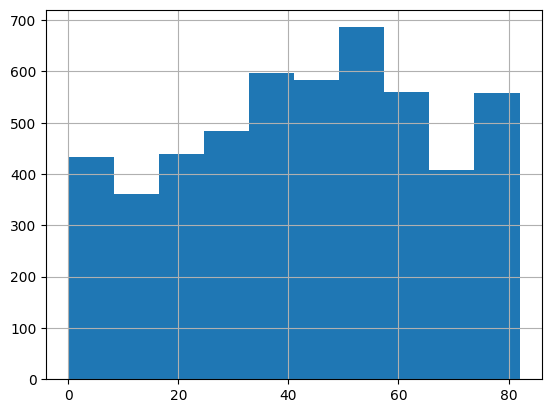

In [27]:
df['age'].hist()

# Preprocessing Data
- **Data cleaning**: Langkah pertama dalam preprocessing biasanya adalah membersihkan data dari masalah kualitas.
- **Encoding variabel kategorikal**: Mengubah data kategorikal menjadi bentuk numerik yang dapat digunakan oleh model, misalnya menggunakan one-hot encoding atau label encoding.
- **Feature scaling**: Normalisasi atau standarisasi fitur numerik sehingga mereka berada dalam rentang atau skala yang serupa.
- **Handling missing values**: Mengisi atau menghapus nilai yang hilang agar data lebih konsisten.
- **Data transformation**: Menerapkan transformasi, seperti log transform atau polynomial transform, untuk meningkatkan performa model.
- **Data splitting**: Memisahkan dataset menjadi set pelatihan (training), validasi, dan pengujian (testing).

## Data Cleaning
- **Menghapus atau mengisi missing values** (nilai yang hilang).
- **Menangani outliers** (nilai-nilai yang sangat jauh dari nilai lainnya).
- **Mengoreksi kesalahan dalam data** seperti kesalahan penulisan, duplikasi data, atau inkonsistensi format.
- **Memperbaiki tipe data** jika ada tipe data yang salah (misalnya, data numerik yang disimpan sebagai teks).
- **Menghapus duplikasi data** atau data yang tidak diperlukan.

### Mengumpulkan Informasi

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [29]:
df.describe(include = 'object')

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


Dari hasil analisis kolom tersebut ditemukan beberapa nilai yang aneh, seperti terdapat tiga 'gender', serta empat 'smoking_status'

In [30]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Nilai minimum age menunjukkan 0.08, seharusnya minimum umur adalah 1

### **Menghapus atau mengisi missing values** (nilai yang hilang)

In [31]:
df.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


Ditemukan 201 data yang kosong pada kolom bmi

In [32]:
df[df['bmi'].isnull()]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,61843,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5039,42007,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,28788,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,32235,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,7293,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


Text(0, 0.5, 'Count')

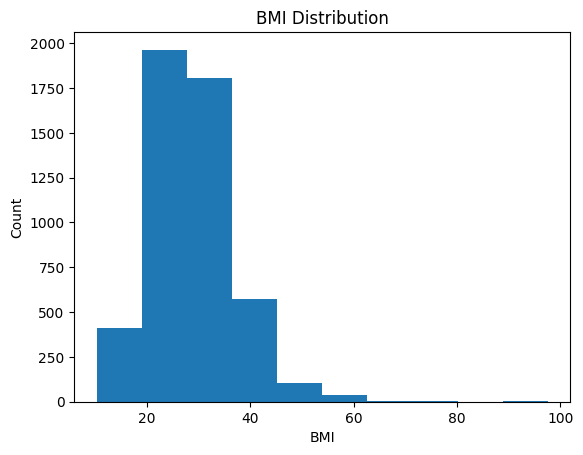

In [33]:
plt.hist(df['bmi'])
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Count')

In [34]:
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

Karena distribusi data bmi tidak normal, maka untuk mengisi value yang kosong menggunakan nilai median bmi

### **Menangani outliers** (nilai-nilai yang sangat jauh dari nilai lainnya)

Text(0, 0.5, 'BMI')

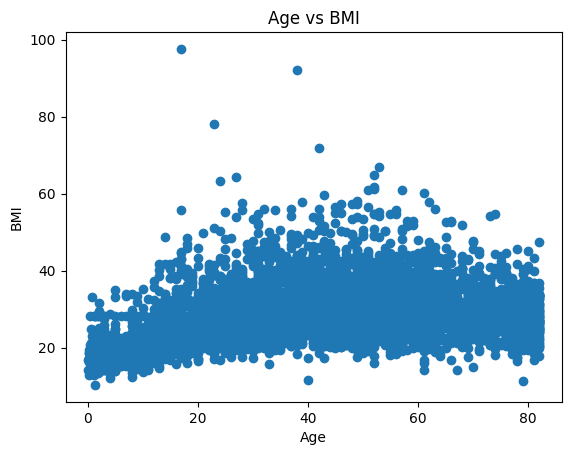

In [35]:
plt.scatter(df['age'], df['bmi'])
plt.title('Age vs BMI')
plt.xlabel('Age')
plt.ylabel('BMI')

In [36]:
df[df['bmi'] > 75]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
928,41097,Female,23.0,1,0,No,Private,Urban,70.03,78.0,smokes,0
2128,56420,Male,17.0,1,0,No,Private,Rural,61.67,97.6,Unknown,0
4209,51856,Male,38.0,1,0,Yes,Private,Rural,56.90,92.0,never smoked,0


Dari Scatter Plot tersebut terdapat beberapa nilai 'bmi' yang jauh dari nilai lainnya, kemungkinan data tersebut merupakan outlier. Sebaiknya menghapus data tersebut.

---

Text(0, 0.5, 'BMI')

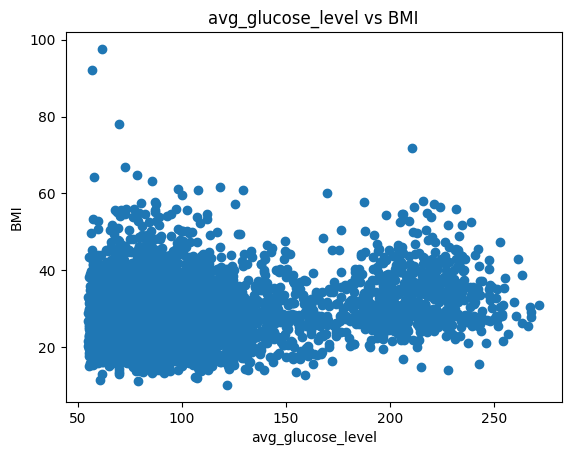

In [37]:
plt.scatter(df['avg_glucose_level'], df['bmi'])
plt.title('avg_glucose_level vs BMI')
plt.xlabel('avg_glucose_level')
plt.ylabel('BMI')

In [38]:
df[df['bmi'] > 70]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
544,545,Male,42.0,0,0,Yes,Private,Rural,210.48,71.9,never smoked,0
928,41097,Female,23.0,1,0,No,Private,Urban,70.03,78.0,smokes,0
2128,56420,Male,17.0,1,0,No,Private,Rural,61.67,97.6,Unknown,0
4209,51856,Male,38.0,1,0,Yes,Private,Rural,56.90,92.0,never smoked,0


Juga terdapat satu data yang terindikasi outlier dikarenakan hubungan bmi dan rata-rata tingkat glukosa yang berbeda dari nilai yang lain. Sebaiknya menghapus data itu.

In [39]:
df = df[df['bmi'] <= 70]
df['bmi'].value_counts()

,count
bmi,
28.1,230
28.7,41
28.4,38
26.7,37
27.7,37
...,...
40.7,1
61.2,1
48.0,1


### **Mengoreksi kesalahan dalam data** seperti kesalahan penulisan, duplikasi data, atau inkonsistensi format

In [40]:
df['gender'].value_counts()

,count
gender,
Female,2993
Male,2112
Other,1


Ternyata terdapat satu kategori gender yang kurang tepat, untuk mempermudah training data maka nilai 'Other' pada kolom 'gender' akan dihapus.

In [41]:
df = df[df['gender'] != 'Other']
df['gender'].value_counts()

,count
gender,
Female,2993
Male,2112


---

In [42]:
df['smoking_status'].value_counts()

,count
smoking_status,
never smoked,1890
Unknown,1543
formerly smoked,884
smokes,788


Ternyata terdapat 1544 data 'Unknown' pada kolom 'smoking_status'

In [43]:
df.groupby('work_type')['stroke'].value_counts()

work_type      stroke
Govt_job       0          624
               1           33
Never_worked   0           22
Private        0         2771
               1          149
Self-employed  0          754
               1           65
children       0          685
               1            2
Name: count, dtype: int64

In [44]:
df = df[df['work_type'] != 'Never_worked']
df.groupby('work_type')['stroke'].value_counts()

work_type      stroke
Govt_job       0          624
               1           33
Private        0         2771
               1          149
Self-employed  0          754
               1           65
children       0          685
               1            2
Name: count, dtype: int64

In [45]:
df = df[df['work_type'] != 'children']
df.groupby('work_type')['stroke'].value_counts(normalize = True)

work_type      stroke
Govt_job       0         0.949772
               1         0.050228
Private        0         0.948973
               1         0.051027
Self-employed  0         0.920635
               1         0.079365
Name: proportion, dtype: float64

Menghapus data orang yang anak-anak dan tidak bekerja

### **Menghapus duplikasi data** atau data yang tidak diperlukan

In [46]:
df[df['id'].duplicated()]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


Tidak ada data duplikat pada dataset

In [47]:
df.drop(columns = 'id', inplace = True)

Karena kolom 'id' sudah tidak digunakan maka kolom dihapus untuk mempermudah analisis data

## Encoding Variabel Kategorikal

In [48]:
enc_df = pd.get_dummies(df[['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']], drop_first=True).astype(int)
enc_df.head()

,gender_Male,ever_married_Yes,work_type_Private,work_type_Self-employed,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,1,1,0,1,1,0,0
1,0,1,0,1,0,0,1,0
2,1,1,1,0,0,0,1,0
3,0,1,1,0,1,0,0,1
4,0,1,0,1,0,0,1,0


In [49]:
clean_df = pd.concat([df, enc_df], axis=1)
clean_df.drop(columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], inplace = True)
clean_df

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Private,work_type_Self-employed,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,1,1,1,0,1,1,0,0
1,61.0,0,0,202.21,28.1,1,0,1,0,1,0,0,1,0
2,80.0,0,1,105.92,32.5,1,1,1,1,0,0,0,1,0
3,49.0,0,0,171.23,34.4,1,0,1,1,0,1,0,0,1
4,79.0,1,0,174.12,24.0,1,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1,0,83.75,28.1,0,0,1,1,0,1,0,1,0
5106,81.0,0,0,125.20,40.0,0,0,1,0,1,1,0,1,0
5107,35.0,0,0,82.99,30.6,0,0,1,0,1,0,0,1,0
5108,51.0,0,0,166.29,25.6,0,1,1,1,0,0,1,0,0


Melakukan One Hot Encoding pada kolom yang datanya nominal untuk melakukan scaling

## Data Splitting

In [50]:
X = clean_df.drop(['stroke'], axis=1)
y = clean_df['stroke']

Memisahkan data dependen dan independen

## Feature scaling

In [51]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

Menggunakan SMOTE untuk scaling dataset agar perbandingan data menjadi setara.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.2,
                                                    random_state=42)

In [53]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6638, 13), (1660, 13), (6638,), (1660,))

# Modeling

## Cross Validation

In [54]:
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

cv_dt = cross_val_score(dt, X_train, y_train, cv=5)
cv_rf = cross_val_score(rf, X_train, y_train, cv=5)

print(cv_dt)
print(cv_rf)

print(f'Decision Tree: {cv_dt.mean()}')
print(f'Random Forest: {cv_rf.mean()}')

[0.89759036 0.88478916 0.89231928 0.89600603 0.89826677]
[0.93373494 0.93674699 0.94126506 0.92765637 0.92614921]
Decision Tree: 0.8937943181921355
Random Forest: 0.9331105128880253


In [55]:
model = ['Decision Tree', 'Random Forest']
cv_mean = [cv_dt.mean(), cv_rf.mean()]
cv_std = [cv_dt.std(), cv_rf.std()]

result = pd.DataFrame({'model': model, 'cv_mean': cv_mean, 'cv_std': cv_std})
result

,model,cv_mean,cv_std
0,Decision Tree,0.893794,0.004951
1,Random Forest,0.933111,0.005627


Berdasarkan Cross Validation, diketahui algoritma Random Forest dengan Hyperparameter Default memiliki skor lebih baik dibandingkan Decision Tree. Oleh karena itu Random Forest akan dilanjutkan ke tahap Hyperparameter Tuning.

## Hyperparameter Tuning

In [56]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

Hyperparameter yang dicoba untuk dilakukan Tuning.

### Grid Search

In [57]:
grid_search = GridSearchCV(estimator=rf,
                           param_grid=rf_params,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(X_train, y_train)

pd.DataFrame(grid_search.cv_results_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.672074,0.025251,0.022154,0.000746,True,5,1,2,100,"{'bootstrap': True, 'max_depth': 5, 'min_sampl...",0.865211,0.831325,0.868223,0.852298,0.837980,0.851008,0.014539,154
1,2.040432,0.445640,0.083173,0.006895,True,5,1,2,200,"{'bootstrap': True, 'max_depth': 5, 'min_sampl...",0.864458,0.833584,0.876506,0.855313,0.837980,0.853568,0.016063,146
2,2.115416,0.331507,0.053348,0.001402,True,5,1,2,300,"{'bootstrap': True, 'max_depth': 5, 'min_sampl...",0.862199,0.831325,0.881777,0.855313,0.840241,0.854171,0.017572,134
3,0.690843,0.066498,0.021453,0.001591,True,5,1,5,100,"{'bootstrap': True, 'max_depth': 5, 'min_sampl...",0.865211,0.832831,0.868223,0.850038,0.837980,0.850857,0.014135,155
4,1.287557,0.024265,0.045920,0.014253,True,5,1,5,200,"{'bootstrap': True, 'max_depth': 5, 'min_sampl...",0.863705,0.834337,0.879518,0.854559,0.837227,0.853869,0.016814,141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,2.460425,0.346304,0.068332,0.017549,False,15,4,5,200,"{'bootstrap': False, 'max_depth': 15, 'min_sam...",0.926205,0.922440,0.931476,0.918613,0.908817,0.921510,0.007638,37
158,4.154297,0.921708,0.099419,0.022144,False,15,4,5,300,"{'bootstrap': False, 'max_depth': 15, 'min_sam...",0.924699,0.924699,0.932229,0.919367,0.914092,0.923017,0.006058,32
159,1.159433,0.024386,0.035536,0.007055,False,15,4,10,100,"{'bootstrap': False, 'max_depth': 15, 'min_sam...",0.923946,0.922440,0.929217,0.914846,0.907310,0.919552,0.007656,42
160,3.307407,0.558226,0.067919,0.012156,False,15,4,10,200,"{'bootstrap': False, 'max_depth': 15, 'min_sam...",0.923193,0.921687,0.931476,0.918613,0.908063,0.920606,0.007580,41


In [58]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Best parameters: {'bootstrap': False, 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.9343154456560228


Hasil menunjukkan skor yang tidak berbeda jauh saat sebelum dilakukan Hyperparameter Tuning.

In [59]:
best_grid_rf = grid_search.best_estimator_
best_grid_rf

RandomForestClassifier(bootstrap=False, max_depth=15, n_estimators=200,
                       random_state=42)

Ditemukan Hyperparameter terbaik adalah (bootstrap=False, max_depth=15, n_estimators=200, random_state=42)

### Random Search

In [60]:
random_search = RandomizedSearchCV(estimator=rf,
                                   param_distributions=rf_params,
                                   n_iter=10,
                                   cv=5,
                                   scoring='accuracy',
                                   n_jobs=-1,
                                   verbose=2,
                                   random_state=42)

random_search.fit(X_train, y_train)

pd.DataFrame(random_search.cv_results_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.573099,0.092178,0.095080,0.004474,300,5,4,15,False,"{'n_estimators': 300, 'min_samples_split': 5, ...",0.924699,0.924699,0.932229,0.919367,0.914092,0.923017,0.006058,3
1,3.003013,0.559447,0.068539,0.021337,200,2,1,10,False,"{'n_estimators': 200, 'min_samples_split': 2, ...",0.916416,0.915663,0.926205,0.920121,0.908817,0.917444,0.005702,4
2,3.019833,0.040924,0.077378,0.004968,300,5,4,10,False,"{'n_estimators': 300, 'min_samples_split': 5, ...",0.911145,0.909639,0.924699,0.908063,0.901281,0.910965,0.007650,6
3,2.955383,0.511828,0.090702,0.027587,200,2,1,15,True,"{'n_estimators': 200, 'min_samples_split': 2, ...",0.936747,0.932229,0.941265,0.928410,0.923888,0.932508,0.006096,1
4,1.321521,0.017488,0.038334,0.003023,200,5,2,5,False,"{'n_estimators': 200, 'min_samples_split': 5, ...",0.859940,0.829819,0.881024,0.859081,0.842502,0.854473,0.017362,8
5,2.820366,0.281886,0.085362,0.007889,300,2,1,10,True,"{'n_estimators': 300, 'min_samples_split': 2, ...",0.910392,0.914157,0.931476,0.911078,0.905803,0.914581,0.008860,5
6,2.652548,0.654906,0.062525,0.020152,300,2,4,5,False,"{'n_estimators': 300, 'min_samples_split': 2, ...",0.859940,0.829819,0.878012,0.856066,0.844763,0.853720,0.016036,10
7,0.846722,0.005067,0.035645,0.008049,100,10,4,10,True,"{'n_estimators': 100, 'min_samples_split': 10,...",0.905873,0.896084,0.924699,0.904295,0.889977,0.904186,0.011757,7
8,1.341554,0.020908,0.042309,0.003844,200,2,4,5,False,"{'n_estimators': 200, 'min_samples_split': 2, ...",0.859940,0.829819,0.878765,0.857573,0.843255,0.853871,0.016501,9
9,1.615699,0.360135,0.046037,0.010493,100,2,2,15,False,"{'n_estimators': 100, 'min_samples_split': 2, ...",0.935241,0.924699,0.932982,0.926903,0.923888,0.928743,0.004550,2


In [61]:
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_}")

Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 15, 'bootstrap': True}
Best cross-validation score: 0.932507876267693


Hasil yang didapat saat menggunakan Random search tidak berbeda jauh dengan Grid Search, oleh karena itu lebih baik menggunakan Random search untuk menghemat waktu.

In [62]:
best_random_rf = random_search.best_estimator_
best_random_rf

RandomForestClassifier(max_depth=15, n_estimators=200, random_state=42)

# Model Evaluation

In [63]:
y_train_pred = best_grid_rf.predict(X_train)
y_test_pred = best_grid_rf.predict(X_test)

In [64]:
print('Train Result')
print('precision:', precision_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))
print('-----------------------------------')
print('Test Result')
print('precision:', precision_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print('-----------------------------------')

Train Result
precision: 0.9883268482490273
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3336
           1       0.99      1.00      0.99      3302

    accuracy                           0.99      6638
   macro avg       0.99      0.99      0.99      6638
weighted avg       0.99      0.99      0.99      6638

-----------------------------------
Test Result
precision: 0.9377203290246768
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       813
           1       0.94      0.94      0.94       847

    accuracy                           0.94      1660
   macro avg       0.94      0.94      0.94      1660
weighted avg       0.94      0.94      0.94      1660

-----------------------------------


Skor yang didapatkan cukup tinggi, walaupun keduanya memiliki perbedaan sebesar lima persen

Train Result


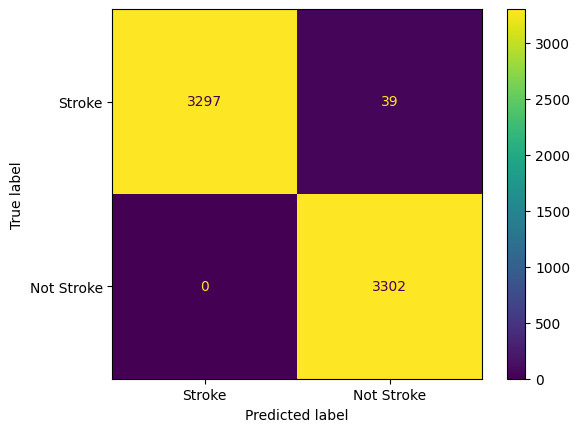

-----------------------------------
Test Result


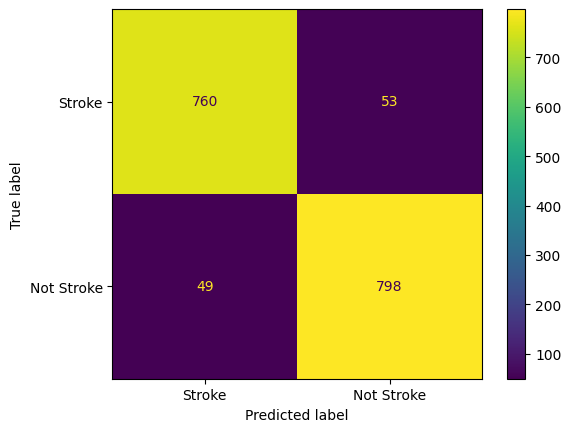

In [65]:
print('Train Result')
train_mtx = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(train_mtx, display_labels=['Stroke', 'Not Stroke']).plot()
plt.show()
print('-----------------------------------')
print('Test Result')
test_mtx = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(test_mtx, display_labels=['Stroke', 'Not Stroke']).plot()
plt.show()